In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ast
from IPython.display import clear_output
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

file_path = "MLPC2025_classification"
label_path = "MLPC2025_classification/labels"
audio_path = "MLPC2025_classification/audio/"

annotations_df = metadata_df = pd.read_csv("MLPC2025_classification/annotations.csv")
annotations_df['categories'] = annotations_df['categories'].apply(lambda x: ast.literal_eval(x))

In [2]:
random.seed(2205)

# Get all classes
label_list = list(np.load(os.path.join(label_path, "14_labels.npz")).keys())

# Select a subset of 10
label_subset = random.sample(label_list, 10)
print(label_subset)

['Rain', 'Car', 'Piano', 'Footsteps', 'Cat Meow', 'Laughter', 'Cowbell', 'Singing', 'Hiccup', 'Bus']


In [3]:
samples = {}

for label in label_subset:
    samples[label] = annotations_df[annotations_df['categories'].apply(lambda x : label in x)].sample(n=10, random_state=42)

In [4]:
#### User test

for label, df in samples.items():
    for row in df.iterrows():
        task_id = row[1].iloc[0]
        filename = row[1].iloc[1]
        onset = row[1].iloc[4]
        offset = row[1].iloc[5]
        original_caption = row[1].iloc[7]
        categories = row[1].iloc[8]
        print(f"{task_id} & {original_caption} & {categories} & \\\\\\hline")
        #input("Next")
    print()
        

161981398 & it is raining. & ['Rain'] & \\\hline
161991032 & Sounds of rain from inside a car. & ['Rain'] & \\\hline
161980437 & rain falling down & ['Rain'] & \\\hline
161990686 & Raindrops ticking muffled in a repeating pattern in front of the porch. & ['Rain'] & \\\hline
161980288 & even, dense rain sound listen from inside & ['Rain'] & \\\hline
161981577 & faint continuous rain sound  & ['Rain'] & \\\hline
161991032 & A windshield wiper wiping rain. & ['Rain'] & \\\hline
161980175 & Loud constant heavy rain outside & ['Rain'] & \\\hline
161980409 & Rain water is gurgling loudly outside. & ['Rain', 'Stream/River'] & \\\hline
161980895 & Water rains into a pool. & ['Rain'] & \\\hline

161992694 & Urban traffic ambience with honking, metallic clangs, and passing vehicles, including a mix of mid-frequency rumbles and brief horn bursts in a reverberant environment. & ['Horn Honk', 'Car'] & \\\hline
161991046 & a car hitting a bump & ['Car'] & \\\hline
161984540 & cars on the road in the

In [5]:
sample_files = {}

for label, df in samples.items():

    l = []    
    for row in df.iterrows():
        l.append(row[1].iloc[1])
    
    sample_files[label] = l

print(sample_files)

{'Rain': ['316849.mp3', '616584.mp3', '486423.mp3', '17074.mp3', '36061.mp3', '695874.mp3', '616584.mp3', '169211.mp3', '465671.mp3', '279008.mp3'], 'Car': ['438188.mp3', '637347.mp3', '160431.mp3', '742936.mp3', '441881.mp3', '362945.mp3', '628547.mp3', '753556.mp3', '406167.mp3', '23273.mp3'], 'Piano': ['277134.mp3', '196556.mp3', '682894.mp3', '449763.mp3', '178037.mp3', '316071.mp3', '496167.mp3', '774958.mp3', '316025.mp3', '316030.mp3'], 'Footsteps': ['275190.mp3', '159989.mp3', '593653.mp3', '654311.mp3', '718981.mp3', '337106.mp3', '273408.mp3', '553243.mp3', '687405.mp3', '451988.mp3'], 'Cat Meow': ['506122.mp3', '257731.mp3', '593519.mp3', '264311.mp3', '768908.mp3', '263858.mp3', '541264.mp3', '768908.mp3', '577458.mp3', '71025.mp3'], 'Laughter': ['367744.mp3', '684819.mp3', '704448.mp3', '438401.mp3', '78583.mp3', '472611.mp3', '698257.mp3', '611480.mp3', '361538.mp3', '243986.mp3'], 'Cowbell': ['401724.mp3', '27806.mp3', '213125.mp3', '27056.mp3', '476013.mp3', '240538.mp3

In [6]:
data = np.load(file_path + "/labels/316849_labels.npz")

print(data["Rain"].shape)

(167, 1)


In [7]:
def interpret_index(idx):
    if idx < 768:
        return f"embedding[{idx}]"
    elif idx < 832:
        return f"mel[{idx - 768}]"
    elif idx < 864:
        return f"mfcc[{idx - 832}]"
    elif idx < 896:
        return f"delta_mfcc[{idx - 864}]"
    elif idx < 928:
        return f"delta2_mfcc[{idx - 896}]"
    elif idx == 928:
        return "flatness"
    elif idx == 929:
        return "centroid"
    elif idx == 930:
        return "flux"
    elif idx == 931:
        return "energy"
    elif idx == 932:
        return "power"
    elif idx == 933:
        return "bandwidth"
    elif 934 <= idx < 941:
        return f"contrast[{idx - 934}]"
    elif idx == 941:
        return "zcr"

In [8]:

mi_scores_classes = {}

for label in sample_files:

    print(label)
    mi_scores = []
    
    for sample in sample_files[label]:

        fname = sample.replace(".mp3", "")
        print(fname)
    
        try:
            data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
            y = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)
            
            X = np.concatenate([
                data_feature['embeddings'],                     # (n, 768)
                data_feature['melspectrogram'],                 # (n, 64)
                data_feature['mfcc'],                           # (n, 32)
                data_feature['mfcc_delta'],                     # (n, 32)
                data_feature['mfcc_delta2'],                    # (n, 32)
                data_feature['flatness'],                       # (n, 1)
                data_feature['centroid'],                       # (n, 1)
                data_feature['flux'],                           # (n, 1)
                data_feature['energy'],                         # (n, 1)
                data_feature['power'],                          # (n, 1)
                data_feature['bandwidth'],                      # (n, 1)
                data_feature['contrast'],                       # (n, 7)
                data_feature['zerocrossingrate']                # (n, 1)
            ], axis=1)
            
            mi = mutual_info_classif(X, y)
            mi = mi_scores.append(mi)
    
        except Exception as e:
            print(f"Error with {fname}: {e}")

    mi_scores_classes[label] = mi_scores
    

Rain
316849
616584
486423
17074
36061
695874
616584
169211
465671
279008
Car
438188
637347
160431
742936
441881
362945
628547
753556
406167
23273
Piano
277134
196556
682894
449763
178037
316071
496167
774958
316025
316030
Footsteps
275190
159989
593653
654311
718981
337106
273408
553243
687405
451988
Cat Meow
506122
257731
593519
264311
768908
263858
541264
768908
577458
71025
Laughter
367744
684819
704448
438401
78583
472611
698257
611480
361538
243986
Cowbell
401724
27806
213125
27056
476013
240538
27056
269217
240538
476014
Singing
575834
171092
770327
255544
422488
331009
624547
737205
546430
157205
Hiccup
369799
582224
547223
369799
273200
141707
369799
547223
405204
428635
Bus
656090
582966
398091
94675
708192
113327
425989
440618
405083
146378


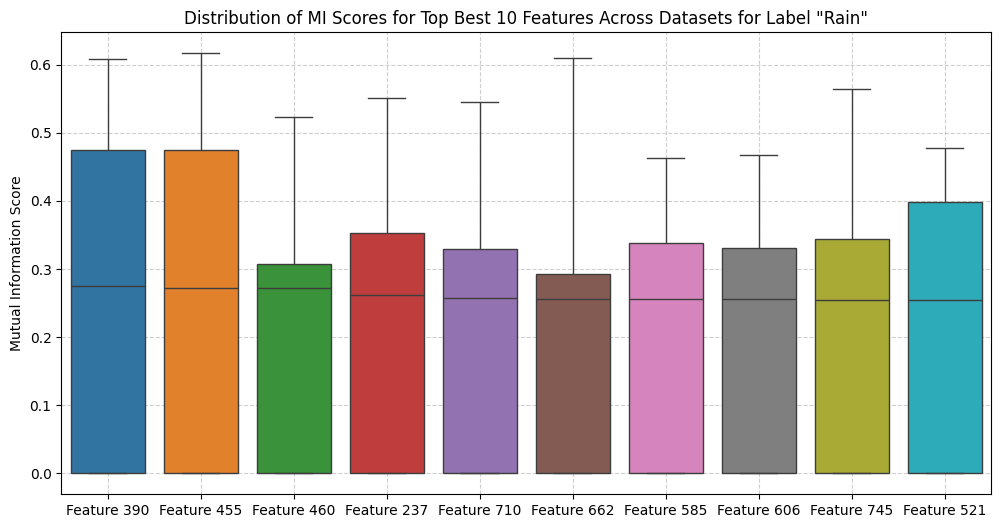

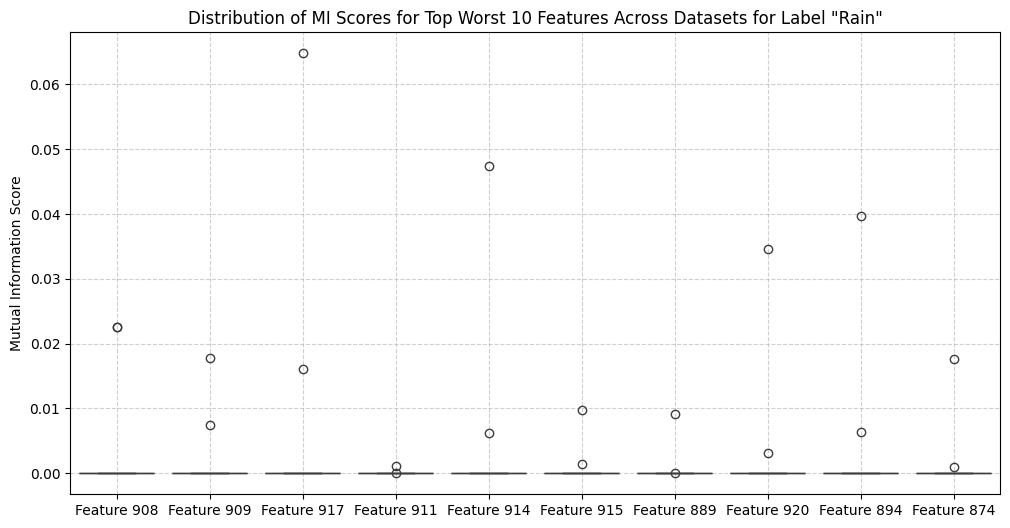

In [9]:
label = label_subset[0]
mi_scores = np.array(mi_scores_classes[label])

mean_mi = np.median(mi_scores, axis=0)

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(-mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Best 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Worst 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

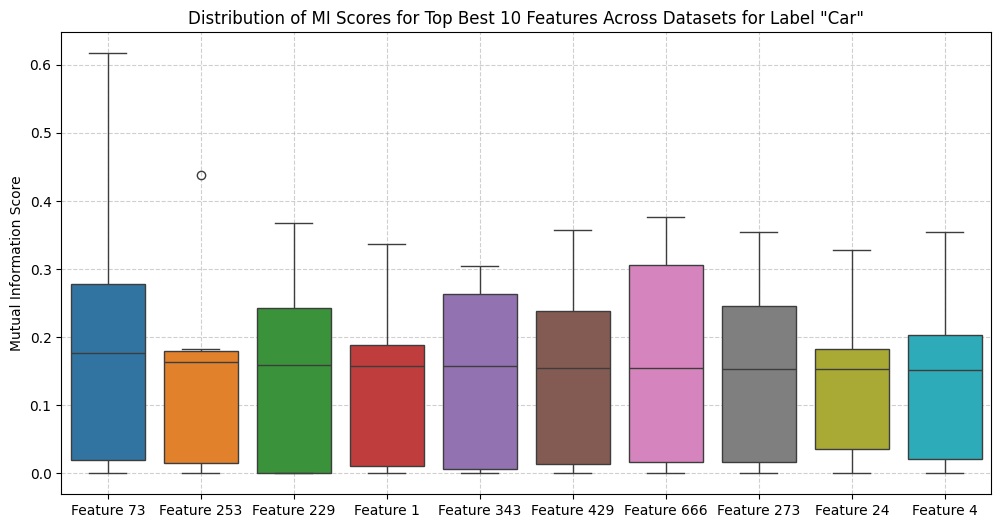

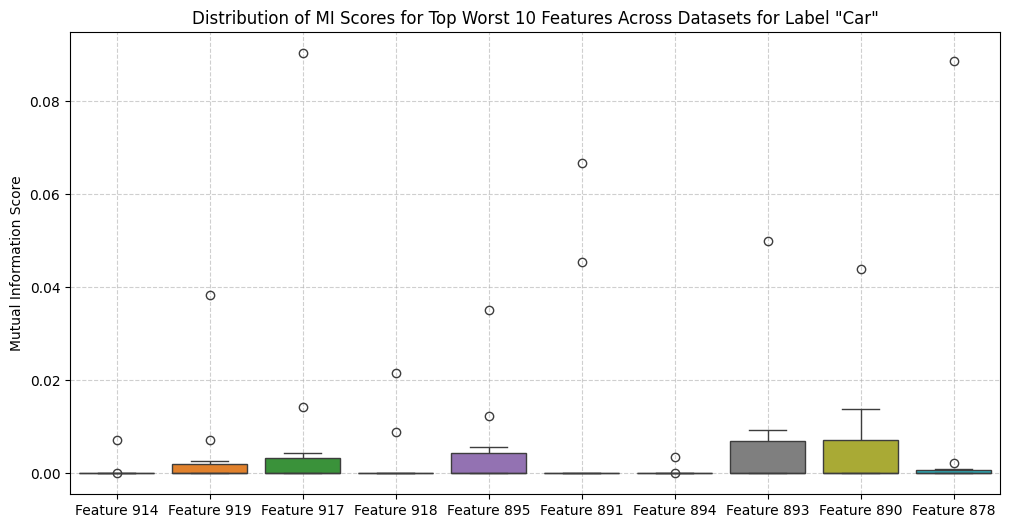

In [10]:
label = label_subset[1]
mi_scores = np.array(mi_scores_classes[label])

mean_mi = np.median(mi_scores, axis=0)

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(-mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Best 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Worst 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

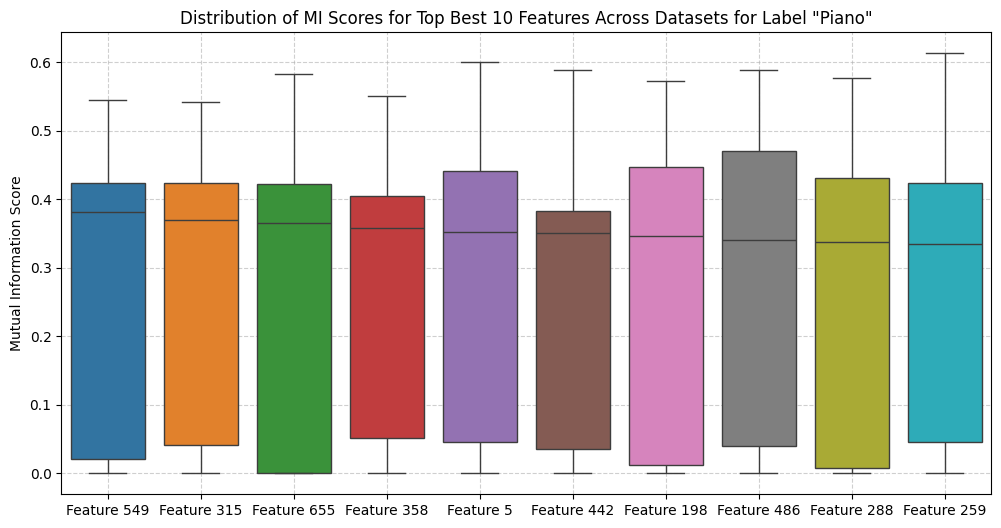

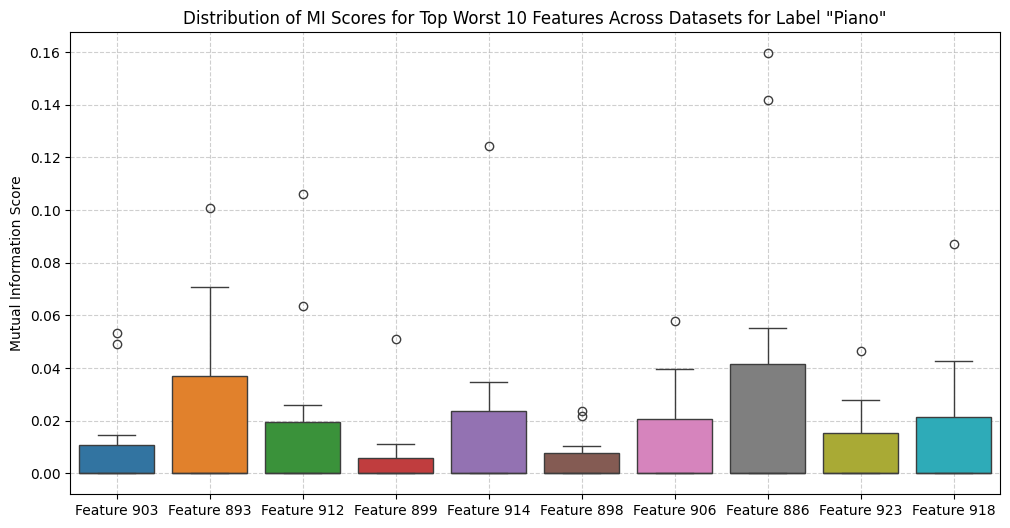

In [11]:
label = label_subset[2]
mi_scores = np.array(mi_scores_classes[label])

mean_mi = np.median(mi_scores, axis=0)

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(-mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Best 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Worst 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

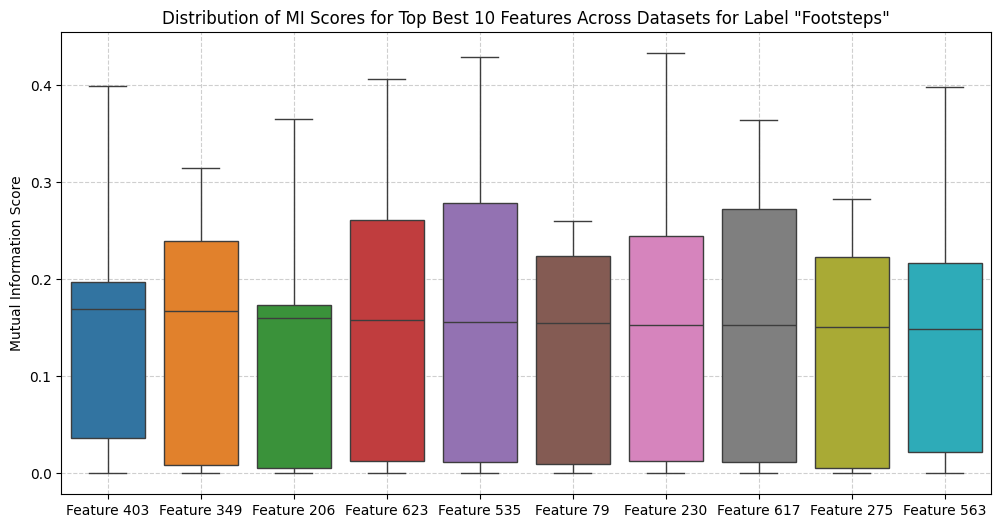

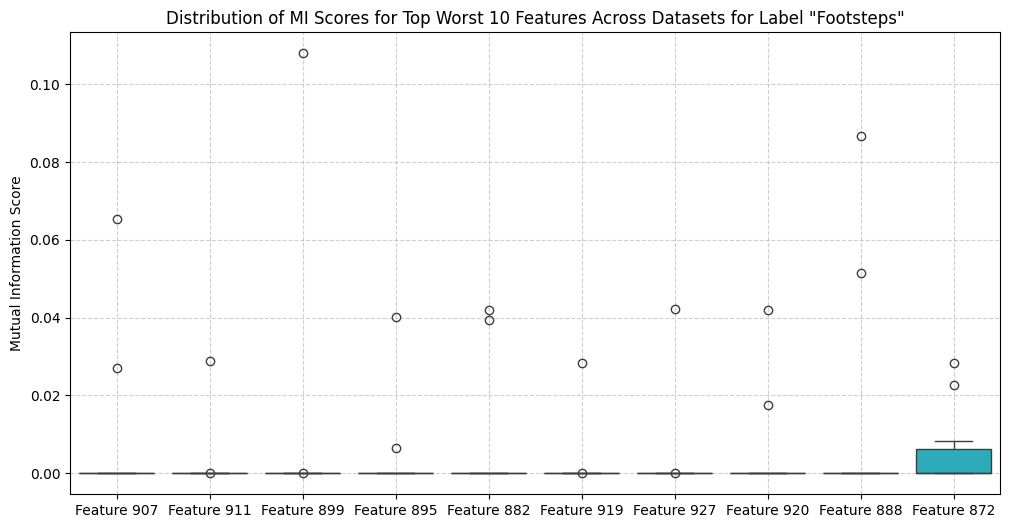

In [12]:
label = label_subset[3]
mi_scores = np.array(mi_scores_classes[label])

mean_mi = np.median(mi_scores, axis=0)

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(-mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Best 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Worst 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

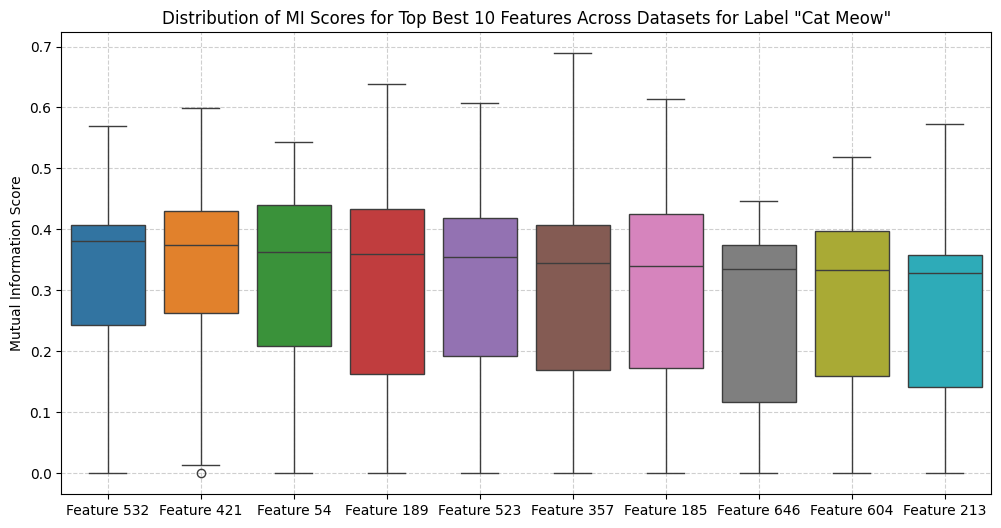

['delta2_mfcc[29]', 'contrast[1]', 'mel[0]', 'contrast[0]', 'mel[1]', 'delta2_mfcc[23]', 'delta2_mfcc[30]', 'mel[3]', 'embedding[115]', 'mfcc[29]']


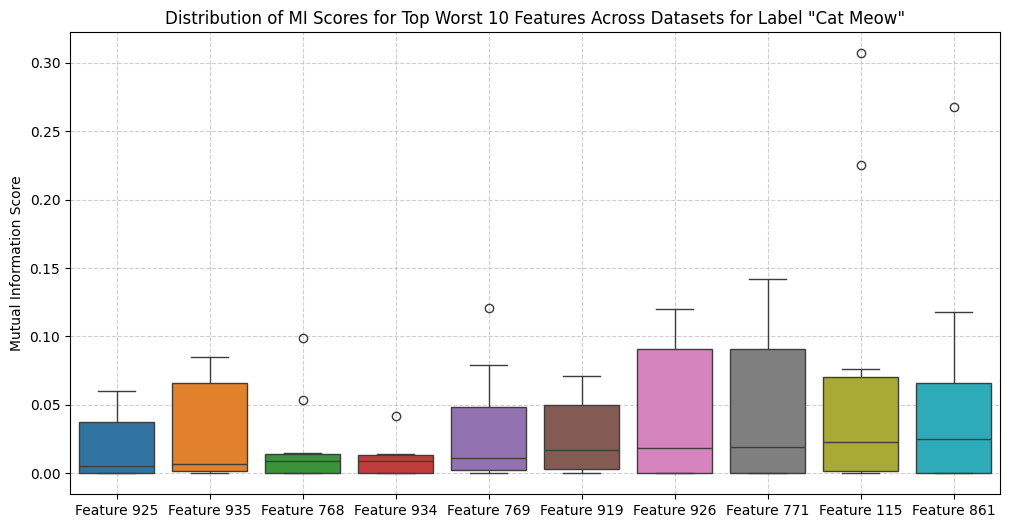

In [13]:
label = label_subset[4]
mi_scores = np.array(mi_scores_classes[label])

mean_mi = np.median(mi_scores, axis=0)

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(-mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Best 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Step 1: Get indices of top 10 features by mean MI
top_10_indices = np.argsort(mean_mi)[:10]

# Step 2: Extract MI scores of top 10 features across datasets
top_10_mi_scores = mi_scores[:, top_10_indices]  # shape: (n_datasets, 10)
print([interpret_index(i) for i in top_10_indices])

# Step 3: Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_mi_scores)
plt.xticks(ticks=range(10), labels=[f"Feature {i}" for i in top_10_indices])
plt.ylabel("Mutual Information Score")
plt.title(f"Distribution of MI Scores for Top Worst 10 Features Across Datasets for Label \"{label}\"")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

316849
616584
486423
17074
36061
695874
616584
169211
465671
279008


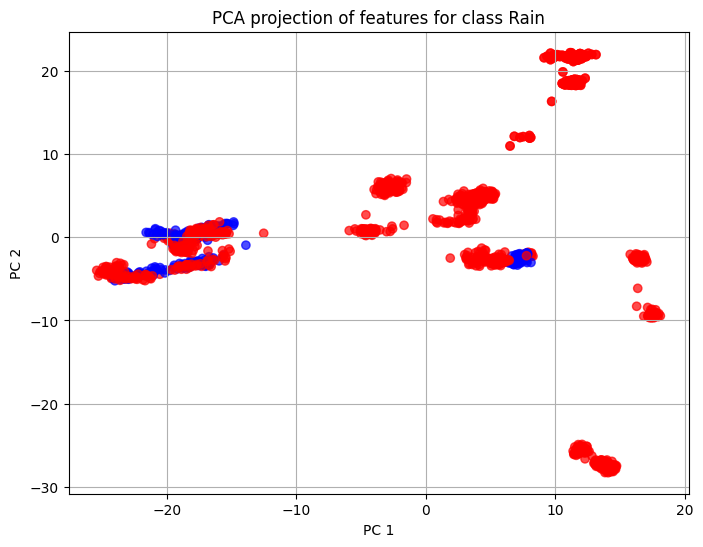

438188
637347
160431
742936
441881
362945
628547
753556
406167
23273


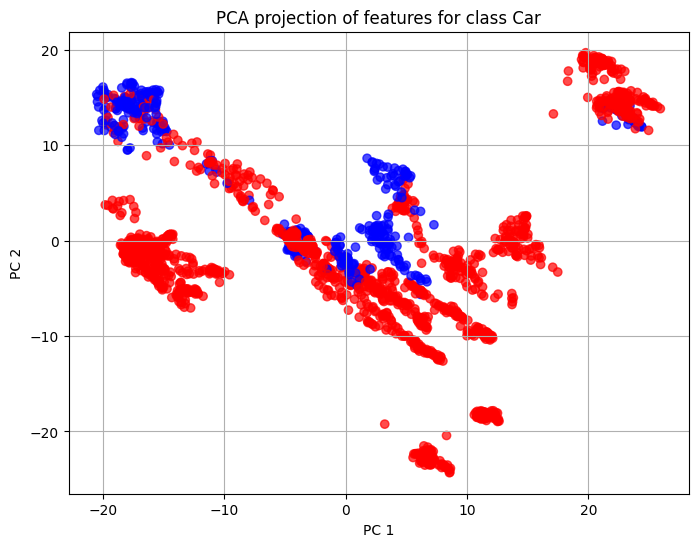

277134
196556
682894
449763
178037
316071
496167
774958
316025
316030


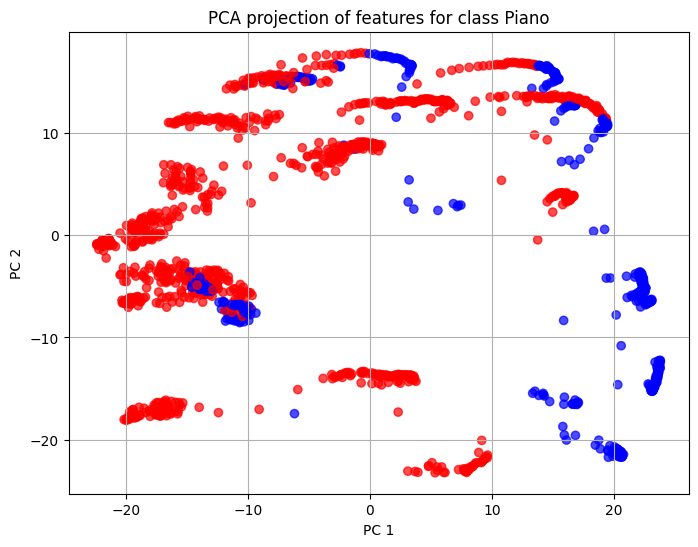

275190
159989
593653
654311
718981
337106
273408
553243
687405
451988


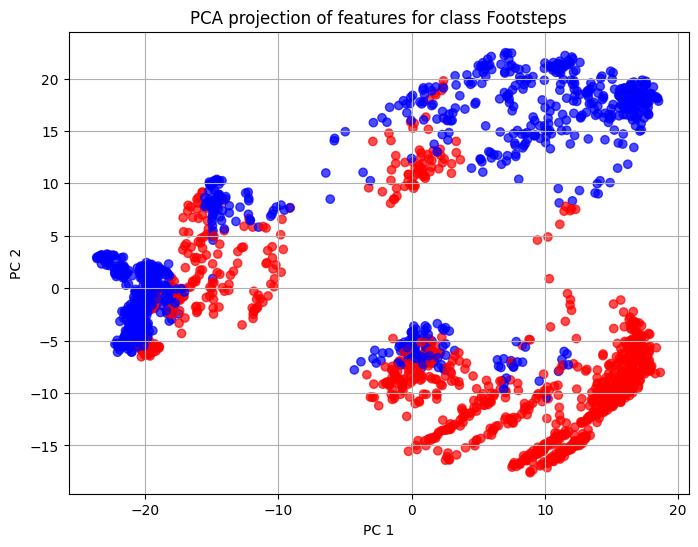

506122
257731
593519
264311
768908
263858
541264
768908
577458
71025


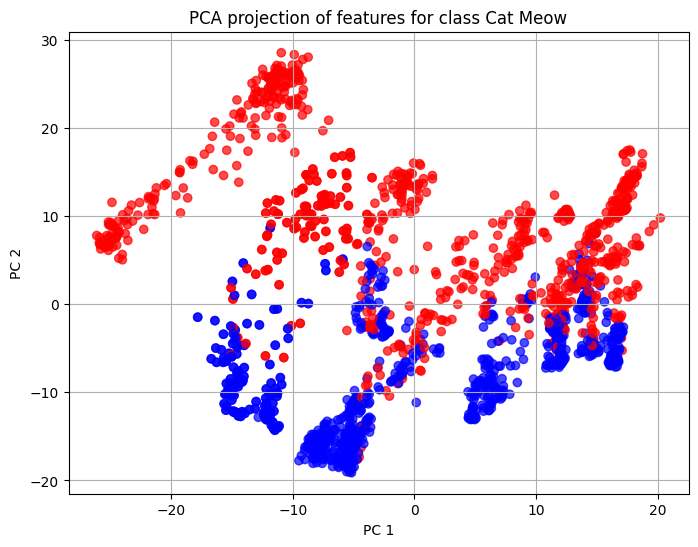

367744
684819
704448
438401
78583
472611
698257
611480
361538
243986


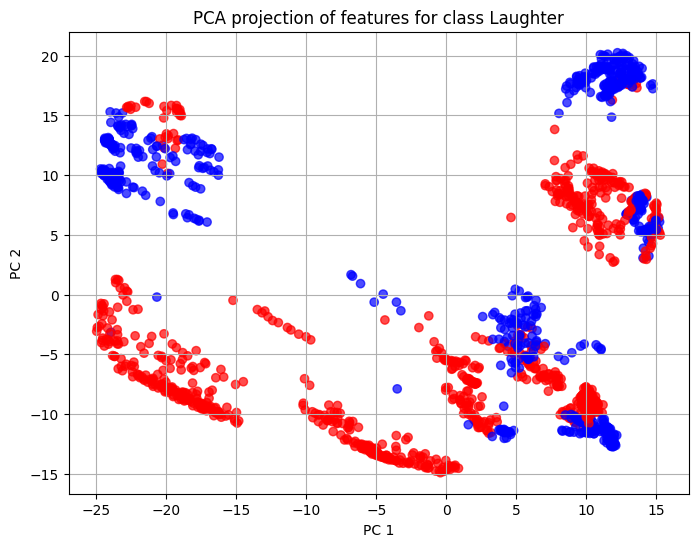

401724
27806
213125
27056
476013
240538
27056
269217
240538
476014


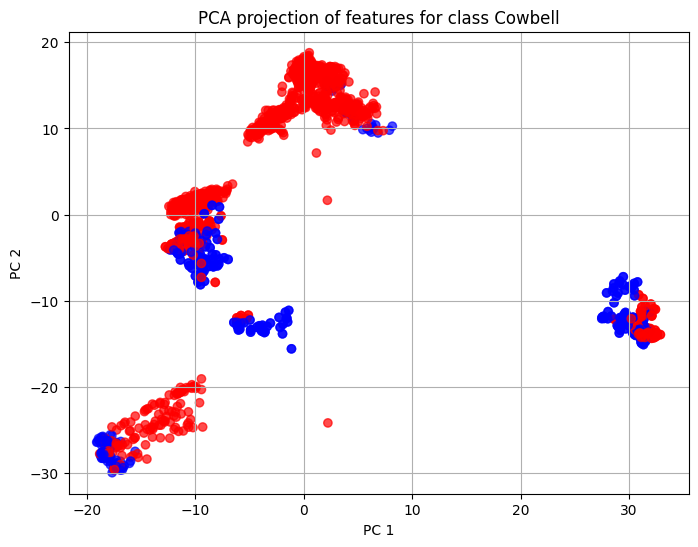

575834
171092
770327
255544
422488
331009
624547
737205
546430
157205


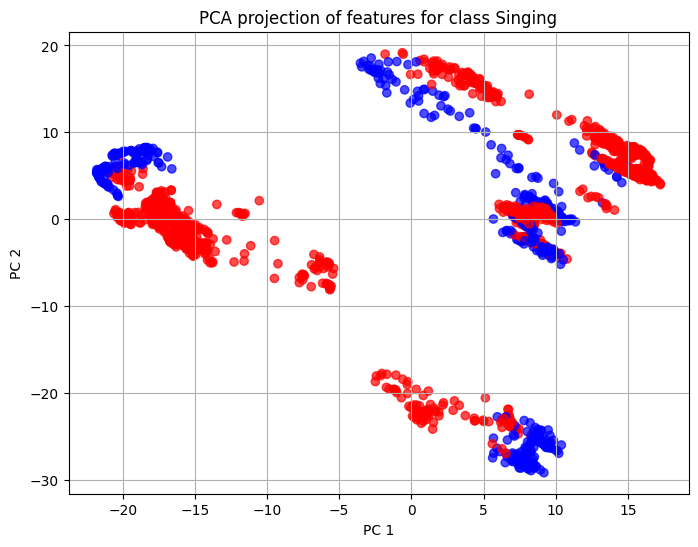

369799
582224
547223
369799
273200
141707
369799
547223
405204
428635


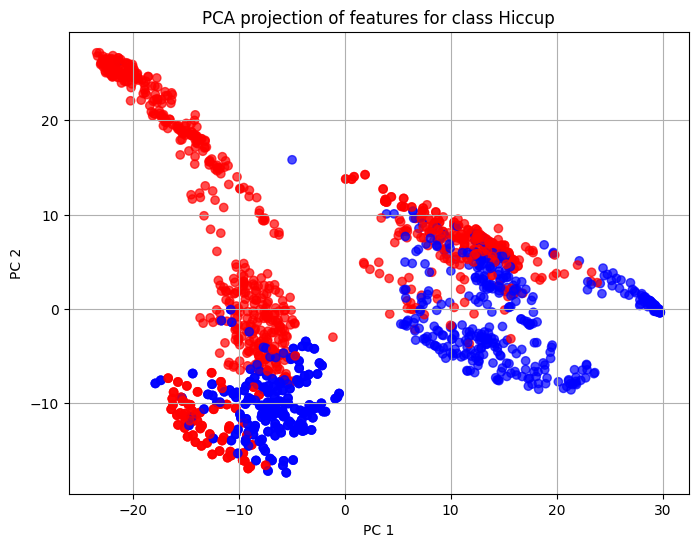

656090
582966
398091
94675
708192
113327
425989
440618
405083
146378


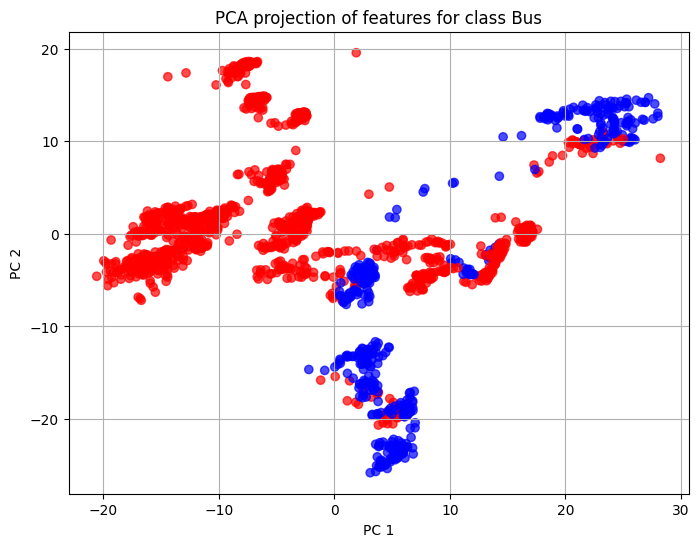

In [14]:


for label in sample_files:
    X = []
    y = []
    frame_feature = []
    frame_label = []
    for sample in sample_files[label]:

        fname = sample.replace(".mp3", "")
        print(fname)
    
        try:
            data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
            label_stack = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)
            
            feature_stack = np.concatenate([
                data_feature['embeddings'],                     # (n, 768)
                data_feature['melspectrogram'],                 # (n, 64)
                data_feature['mfcc'],                           # (n, 32)
                data_feature['mfcc_delta'],                     # (n, 32)
                data_feature['mfcc_delta2'],                    # (n, 32)
                data_feature['flatness'],                       # (n, 1)
                data_feature['centroid'],                       # (n, 1)
                data_feature['flux'],                           # (n, 1)
                data_feature['energy'],                         # (n, 1)
                data_feature['power'],                          # (n, 1)
                data_feature['bandwidth'],                      # (n, 1)
                data_feature['contrast'],                       # (n, 7)
                data_feature['zerocrossingrate']                # (n, 1)
            ], axis=1)
            
            frame_feature.append(feature_stack)
            frame_label.append(label_stack)
    
        except Exception as e:
            print(f"Error with {fname}: {e}")
        #break

    X = np.vstack(frame_feature)
    y = np.concatenate(frame_label)
    
    X_scaled = StandardScaler().fit_transform(X)
            
    # Step 2: Apply PCA to reduce to 2 dimensions (for visualization)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    
    colors = np.where(y == 0, 'b', 'r')
    
    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"PCA projection of features for class {label}")
    plt.grid(True)
    plt.show() 

316849
616584
486423
17074
36061
695874
616584
169211
465671
279008


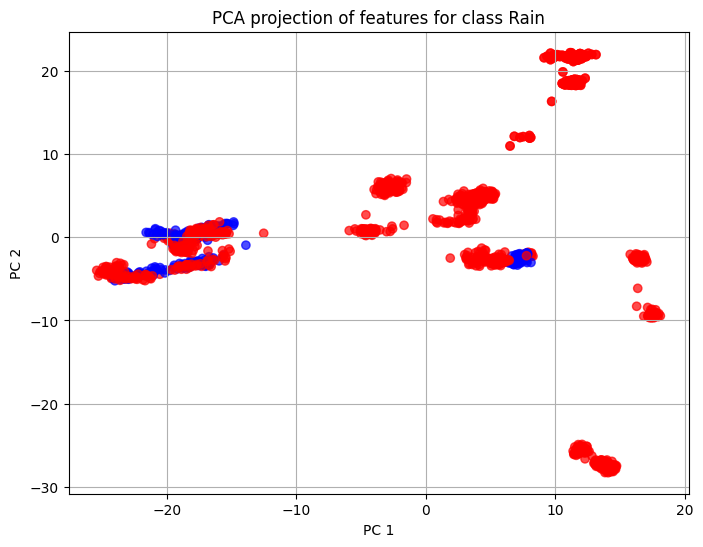

In [15]:
label = 'Rain'
X = []
y = []
frame_feature = []
frame_label = []
for sample in sample_files[label]:

    fname = sample.replace(".mp3", "")
    print(fname)

    try:
        data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
        label_stack = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)
        
        feature_stack = np.concatenate([
            data_feature['embeddings'],                     # (n, 768)
            data_feature['melspectrogram'],                 # (n, 64)
            data_feature['mfcc'],                           # (n, 32)
            data_feature['mfcc_delta'],                     # (n, 32)
            data_feature['mfcc_delta2'],                    # (n, 32)
            data_feature['flatness'],                       # (n, 1)
            data_feature['centroid'],                       # (n, 1)
            data_feature['flux'],                           # (n, 1)
            data_feature['energy'],                         # (n, 1)
            data_feature['power'],                          # (n, 1)
            data_feature['bandwidth'],                      # (n, 1)
            data_feature['contrast'],                       # (n, 7)
            data_feature['zerocrossingrate']                # (n, 1)
        ], axis=1)
        
        frame_feature.append(feature_stack)
        frame_label.append(label_stack)

    except Exception as e:
        print(f"Error with {fname}: {e}")
    #break

X = np.vstack(frame_feature)
y = np.concatenate(frame_label)

X_scaled = StandardScaler().fit_transform(X)
        
# Step 2: Apply PCA to reduce to 2 dimensions (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


colors = np.where(y == 0, 'b', 'r')

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"PCA projection of features for class {label}")
plt.grid(True)
plt.show() 

275190
159989
593653
654311
718981
337106
273408
553243
687405
451988


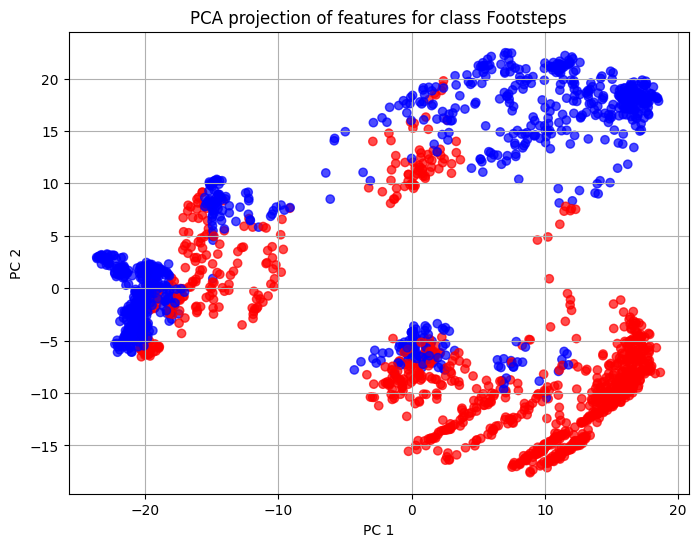

In [16]:
label = 'Footsteps'
X = []
y = []
frame_feature = []
frame_label = []
for sample in sample_files[label]:

    fname = sample.replace(".mp3", "")
    print(fname)

    try:
        data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
        label_stack = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)
        
        feature_stack = np.concatenate([
            data_feature['embeddings'],                     # (n, 768)
            data_feature['melspectrogram'],                 # (n, 64)
            data_feature['mfcc'],                           # (n, 32)
            data_feature['mfcc_delta'],                     # (n, 32)
            data_feature['mfcc_delta2'],                    # (n, 32)
            data_feature['flatness'],                       # (n, 1)
            data_feature['centroid'],                       # (n, 1)
            data_feature['flux'],                           # (n, 1)
            data_feature['energy'],                         # (n, 1)
            data_feature['power'],                          # (n, 1)
            data_feature['bandwidth'],                      # (n, 1)
            data_feature['contrast'],                       # (n, 7)
            data_feature['zerocrossingrate']                # (n, 1)
        ], axis=1)
        
        frame_feature.append(feature_stack)
        frame_label.append(label_stack)

    except Exception as e:
        print(f"Error with {fname}: {e}")
    #break

X = np.vstack(frame_feature)
y = np.concatenate(frame_label)

X_scaled = StandardScaler().fit_transform(X)
        
# Step 2: Apply PCA to reduce to 2 dimensions (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


colors = np.where(y == 0, 'b', 'r')

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"PCA projection of features for class {label}")
plt.grid(True)
plt.show() 

506122
257731
593519
264311
768908
263858
541264
768908
577458
71025


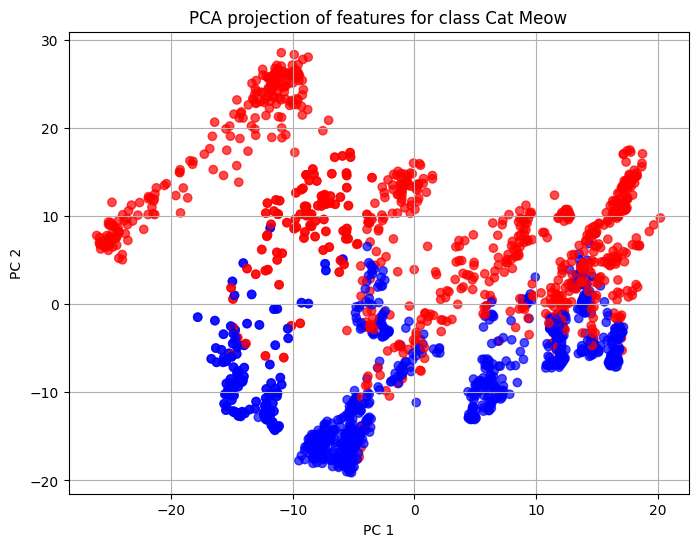

In [17]:
label = 'Cat Meow'
X = []
y = []
frame_feature = []
frame_label = []
for sample in sample_files[label]:

    fname = sample.replace(".mp3", "")
    print(fname)

    try:
        data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
        label_stack = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)
        
        feature_stack = np.concatenate([
            data_feature['embeddings'],                     # (n, 768)
            data_feature['melspectrogram'],                 # (n, 64)
            data_feature['mfcc'],                           # (n, 32)
            data_feature['mfcc_delta'],                     # (n, 32)
            data_feature['mfcc_delta2'],                    # (n, 32)
            data_feature['flatness'],                       # (n, 1)
            data_feature['centroid'],                       # (n, 1)
            data_feature['flux'],                           # (n, 1)
            data_feature['energy'],                         # (n, 1)
            data_feature['power'],                          # (n, 1)
            data_feature['bandwidth'],                      # (n, 1)
            data_feature['contrast'],                       # (n, 7)
            data_feature['zerocrossingrate']                # (n, 1)
        ], axis=1)
        
        frame_feature.append(feature_stack)
        frame_label.append(label_stack)

    except Exception as e:
        print(f"Error with {fname}: {e}")
    #break

X = np.vstack(frame_feature)
y = np.concatenate(frame_label)

X_scaled = StandardScaler().fit_transform(X)
        
# Step 2: Apply PCA to reduce to 2 dimensions (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


colors = np.where(y == 0, 'b', 'r')

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"PCA projection of features for class {label}")
plt.grid(True)
plt.show() 

ONLY EMBEDDING FEATURE

575834
171092
770327
255544
422488
331009
624547
737205
546430
157205


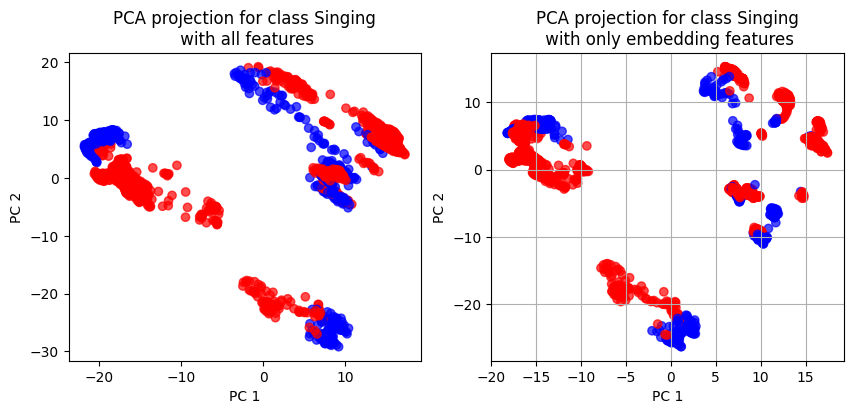

In [67]:
label = 'Singing'
X = []
y = []
frame_feature = []
frame_label = []
frame_embedding = []
for sample in sample_files[label]:

    fname = sample.replace(".mp3", "")
    print(fname)

    try:
        data_feature = np.load(file_path + "/audio_features/" + fname + ".npz")
        label_stack = np.load(file_path + "/labels/" + fname + "_labels.npz")[label].max(-1)

        embeddings_stack = np.concatenate([data_feature['embeddings']], axis=1)
        feature_stack = np.concatenate([
            data_feature['embeddings'],                     # (n, 768)
            data_feature['melspectrogram'],                 # (n, 64)
            data_feature['mfcc'],                           # (n, 32)
            data_feature['mfcc_delta'],                     # (n, 32)
            data_feature['mfcc_delta2'],                    # (n, 32)
            data_feature['flatness'],                       # (n, 1)
            data_feature['centroid'],                       # (n, 1)
            data_feature['flux'],                           # (n, 1)
            data_feature['energy'],                         # (n, 1)
            data_feature['power'],                          # (n, 1)
            data_feature['bandwidth'],                      # (n, 1)
            data_feature['contrast'],                       # (n, 7)
            data_feature['zerocrossingrate']                # (n, 1)
        ], axis=1)
        
        frame_feature.append(feature_stack)
        frame_embedding.append(embeddings_stack)
        frame_label.append(label_stack)

    except Exception as e:
        print(f"Error with {fname}: {e}")
    #break

X1 = np.vstack(frame_feature)
X2 = np.vstack(frame_embedding)
y = np.concatenate(frame_label)

X1_scaled = StandardScaler().fit_transform(X1)
X2_scaled = StandardScaler().fit_transform(X2)
        
# Step 2: Apply PCA to reduce to 2 dimensions (for visualization)
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1_scaled)
X2_pca = pca.fit_transform(X2_scaled)

colors = np.where(y == 0, 'b', 'r')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].scatter(X1_pca[:, 0], X1_pca[:, 1], c=colors, alpha=0.7)
axs[0].set_xlabel("PC 1")
axs[0].set_ylabel("PC 2")
axs[0].set_title(f"PCA projection for class {label}\n with all features")



axs[1].scatter(X2_pca[:, 0], X2_pca[:, 1], c=colors, alpha=0.7)
axs[1].set_xlabel("PC 1")
axs[1].set_ylabel("PC 2")
axs[1].set_title(f"PCA projection for class {label}\n with only embedding features")

plt.grid(True)
plt.show() 